In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [3]:
BATCH_SIZE = 32
IMAGE_SIZEw = 256
IMAGE_SIZEh=256
CHANNELS=3
EPOCHS=30

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZEw,IMAGE_SIZEh),
    batch_size=BATCH_SIZE
)

Found 10407 files belonging to 10 classes.


In [5]:
class_names = dataset.class_names
class_names

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [6]:
len(dataset)

326

In [162]:
326*32

10432

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[5 4 5 9 9 3 0 5 7 4 3 4 0 3 6 8 8 9 9 4 5 2 2 5 9 8 5 7 6 8 5 4]


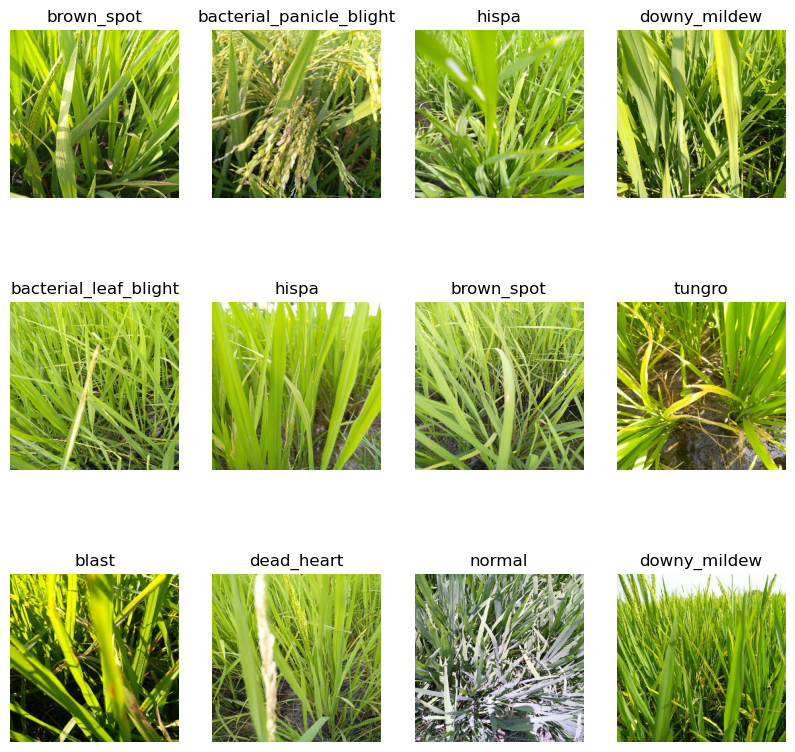

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
train_size = 0.8
len(dataset)*train_size


260.8

In [10]:
train_ds = dataset.take(260)
len(train_ds)

260

In [11]:
test_ds = dataset.skip(260)
len(test_ds)



66

In [12]:
val_size=0.1
len(dataset)*val_size

32.6

In [13]:
val_ds = test_ds.take(32)
len(val_ds)


32

In [14]:
test_ds = test_ds.skip(32)
len(test_ds)

34

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

260

In [18]:
len(val_ds)

32

In [22]:
len(test_ds)

34

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# buffersize tf determine how mANY batches to take
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZEw, IMAGE_SIZEh),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
from tensorflow.keras.optimizers import Adam

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZEw, IMAGE_SIZEh, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [44]:
# optimizer

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [45]:
from tensorflow.keras.optimizers.legacy import Adam

In [46]:
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=40,
)

Epoch 1/40
260/260 [==============================] - 2155s 8s/step - loss: 0.8862 - accuracy: 0.6992 - val_loss: 0.8423 - val_accuracy: 0.7012
Epoch 2/40
260/260 [==============================] - 1610s 6s/step - loss: 0.8443 - accuracy: 0.7172 - val_loss: 0.7603 - val_accuracy: 0.7441
Epoch 3/40
260/260 [==============================] - 1540s 6s/step - loss: 0.8358 - accuracy: 0.7181 - val_loss: 0.8079 - val_accuracy: 0.7354
Epoch 4/40
260/260 [==============================] - 1348s 5s/step - loss: 0.8021 - accuracy: 0.7315 - val_loss: 0.7188 - val_accuracy: 0.7549
Epoch 5/40
260/260 [==============================] - 1271s 5s/step - loss: 0.7759 - accuracy: 0.7356 - val_loss: 0.7437 - val_accuracy: 0.7383
Epoch 6/40
260/260 [==============================] - 1377s 5s/step - loss: 0.7634 - accuracy: 0.7409 - val_loss: 0.6657 - val_accuracy: 0.7744
Epoch 7/40
260/260 [==============================] - 1342s 5s/step - loss: 0.7330 - accuracy: 0.7473 - val_loss: 0.8966 - val_accuracy:

In [47]:
scores = model.evaluate(test_ds)

34/34 [==============================] - 17s 485ms/step - loss: 0.5430 - accuracy: 0.8244


In [48]:
scores

[0.5430458188056946, 0.8244485259056091]

In [49]:
history

In [50]:

history.params

{'verbose': 1, 'epochs': 40, 'steps': 260}

In [51]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [52]:
len(history.history['loss'])

40

In [53]:
history.history['loss'][:5] # show loss for first 5 epochs


[0.8862460851669312,
 0.8443089723587036,
 0.8358226418495178,
 0.8021159172058105,
 0.7758750319480896]

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

first image to predict
actual label: normal
1/1 [==============================] - 1s 666ms/step
predicted label: normal


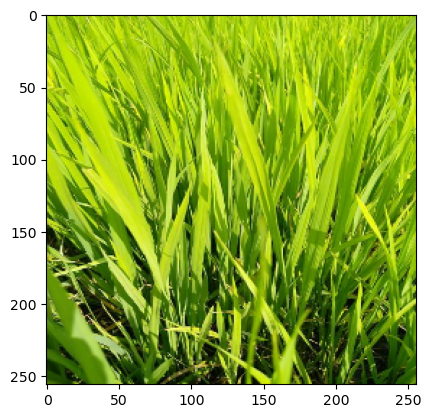

In [56]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [57]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 43ms/step
Cultural methods to prevent this disease is: -

1 Planting resistant varieties against the rice blast is the most practical and economical way of controlling rice blast.
2 Use of Tolerant varieties (CO 47, CO 50, ADT 36,ADT 37,ASD 16,ASD 20,ADT 39,ASD 19,TPS 3,White ponni,ADT 44,BPT 5204,CORH , Palghuna, Swarnamukhi, Swathi, Prabhat, IR - 64, , IR - 36, Jaya).
3 Avoid excess N - fertilizer application
4 Apply nitrogen in three split doses.
5 Remove weed hosts from bunds.


Chemical methods to prevent this disease is: -

1 Do not apply lower/higher doses of fungicides.
2 Spray before 11.00 AM/after 3.00 PM.
3 Avoid noon hours for spraying.
4 Seed treatment at 2.0 g/kg seed with Captan or Carbendazim or Thiram or Tricyclazole.
5 Systemic fungicides such as pyroquilon and tricyclazole are possible chemicals for controlling the disease.
6 Spraying of Tricyclazole at 1g/lit of water or Edifenphos at 1 ml/lit of water or Carbendazim at 1.0 

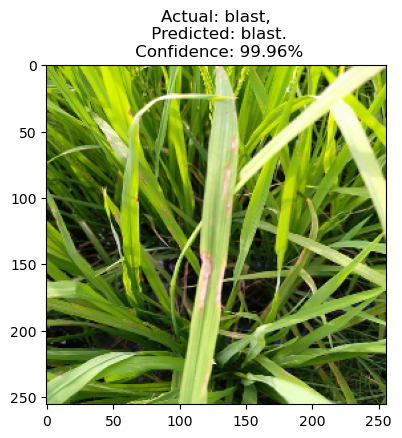

In [161]:
import json
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(1):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
    
        f = open('rice_disease_solution.json')
        data = json.load(f)
        method=data[actual_class]
        print("Cultural methods to prevent this disease is: -")
        print()
        j=1
        for i in method["Cultural methods"]:
               k=j
               print(str(k)+" "+i)
               j=j+1
        j=1 
        print()
        print()
        print("Chemical methods to prevent this disease is: -")
        print()
        for i in method["Chemical methods"]:
               k=j
               print(str(k)+" "+i)
               j=j+1
               

        f.close()
        
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
#         plt.axis("off")

In [59]:
import os
model_version=max([int(i) for i in os.listdir("../model") + [0]])+1
model.save(f"../model/{model_version}")

INFO:tensorflow:Assets written to: ../model/3\assets


INFO:tensorflow:Assets written to: ../model/3\assets
